# Bayesian Linear Regression

This is to reproduce chapter 3 of the book [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book) by Christopher M. Bishop.



In [54]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import numpy as np 
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt 

from basic.basis import Polynomial
from basic.linear import BayesianLinearRegression

np.random.seed(111)

## Likilyhood Function

Suppose we are given a dataset $\mathcal{D}=\left\{({\bf x}_n, y_n)\vert {\bf x}_n \in \mathbb{R}^M, y_n\in\mathbb{R} \right\}_{n=1}^N$. Where each element $y_n$ is modelled as


$$
    y_n\vert {\bf x}_n \sim \mathcal{N}({\bf w}^T{\bf x}, \sigma^2)
$$


## Parameter Distribution


Furthermore, we we assign $\bf w$ a *prior* distribution of the form ${\bf w}\sim\mathcal{N}(\boldsymbol\mu_0, \boldsymbol\Sigma_0)$. Our goal is to find the *posterior* distribution ${\bf w}\vert \mathcal{D}$, i.e.,


$$
\begin{aligned}
p({\bf w}\vert \mathcal{D}) &\propto p({\bf w})p(\mathcal D\vert {\bf w})\\
&= \mathcal{N}({\bf w}\vert \boldsymbol\mu_0, \boldsymbol\Sigma_0) \mathcal{N}({\bf y} \vert {\bf X}{\bf w}, \sigma^2{\bf I})
\end{aligned}
$$

To find the posterior conjugate (a closed-form solution), note that

$$
    {\bf z}^T{\bf A}{\bf z} - 2{\bf z}^T{\bf b} + c = ({\bf z} - {\bf A}^{-1}{\bf b})^T{\bf A}({\bf z} - {\bf A}^{-1}{\bf b}) - {\bf b}^T{\bf A}^{-1}{\bf b} + c
$$

Then,
$$
\begin{align}
    p({\bf w}\vert \mathcal{D}) &\propto \exp\left(-\frac{1}{2} ({\bf w} - \boldsymbol\mu_0)^T\Sigma_0^{-1}({\bf w} - \boldsymbol\mu_0) -\frac{1}{2\sigma^2} ({\bf y} - {\bf X w})^T({\bf y} - {\bf X w}) \right)\\
    &= \exp\left(-\frac{1}{2}\left( ({\bf w} - \boldsymbol\mu_0)^T\Sigma_0^{-1}({\bf w} - \boldsymbol\mu_0) +\frac{1}{\sigma^2} ({\bf y} - {\bf X w})^T({\bf y} - {\bf X w})\right) \right)\\
    &\propto \exp\left(-\frac{1}{2}\left[{\bf w}^T \left(\boldsymbol\Sigma_0^{-1} + \frac{1}{\sigma^2}{\bf X}^T{\bf X}\right) - 2{\bf w}^T \left(\boldsymbol\Sigma_0^{-1}\boldsymbol\mu_0 + \frac{1}{\sigma^2}{\bf X}^T{\bf y}\right) \right]\right)
\end{align}
$$

This last expression reduces to

$$
    p({\bf w}\vert \mathcal{D}) \propto \exp\left(-\frac{1}{2}({\bf w} - {\bf m}_N)^T {\bf S}_N^{-1} ({\bf w} - {\bf m}_N)\right)
$$

Where
* ${\bf S}_N^{-1} = \boldsymbol\Sigma_0^{-1} + \frac{1}{\sigma^2}{\bf X}^T{\bf X}$
* ${\bf m}_N = {\bf S}_N \left(\boldsymbol\Sigma_0^{-1}\boldsymbol\mu_0 + \frac{1}{\sigma^2}{\bf X}^T{\bf y}\right)$

Using a bayesian perspective, there does not exist *a* vector of weights $\bf w$; rather, $\bf w$ is a random variable that we can sample from.

The following is to reproduce Figure 3.7 of the book.

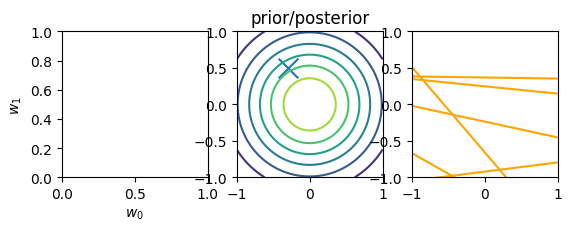

(10000,)


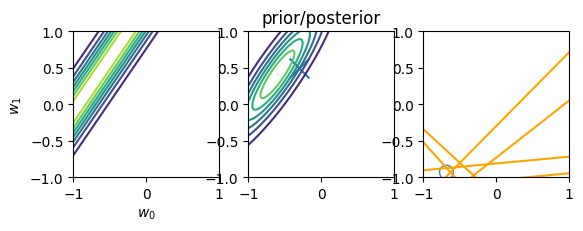

(10000,)


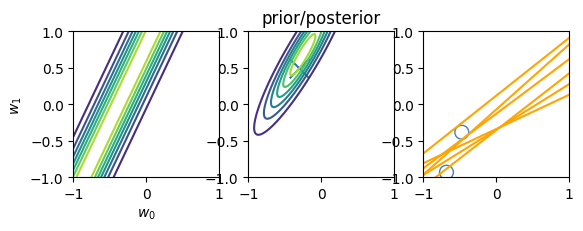

(10000,)


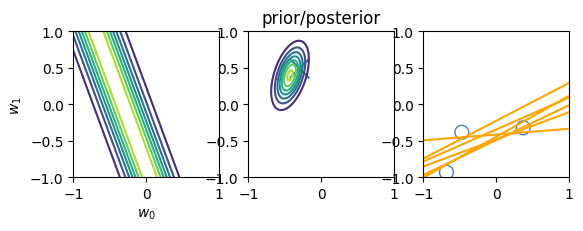

(10000,)


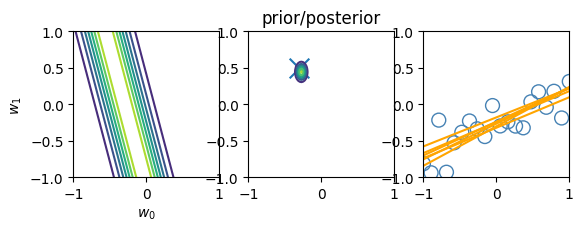

In [55]:
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def linear(x, a0, a1):
    return a0 + a1 * x

# data generation
a0 = -0.3
a1 = 0.5
std = 0.2 
beta = 1/std**2
x_train, y_train = create_toy_data(lambda x: linear(x, a0, a1), 20, std, [-1, 1])
x = np.linspace(-1, 1, 100)

# add polynomial features
basis = Polynomial()
X_train = basis.transform(x_train, degree=1)
X = basis.transform(x, degree=1)

# bayesian linear regression
bayesian = BayesianLinearRegression()

# initialize prior distribution of w
w0, w1 = np.meshgrid(
    np.linspace(-1, 1, 100),
    np.linspace(-1, 1, 100))
w = np.array([w0, w1]).transpose(1, 2, 0)

alpha = 2.0 # precision of noise
w_mean, w_var = bayesian.init_w_prior(X_train, alpha)

# plot
for begin, end in [[0,0], [0, 1], [1, 2], [2, 3], [3, 20]]:

    plt.subplot(1,3,1)
    if end > 0:
        # calculate maximum likelihood pdf of current incomming point
        y_obs = y_train[end-1]
        x_obs = X_train[end-1]
        like_mean = w.reshape(-1,2) @ x_obs.T
        like_std = std
        print(like_mean.shape)
        likelihood = norm.pdf(y_obs, loc=like_mean, scale=like_std)
        likelihood = likelihood.reshape(100,100)
        plt.contour(w0, w1, likelihood)
        w_mean, w_var = bayesian.fit(beta, w_mean, w_var, X_train[begin: end], y_train[begin: end])
    plt.gca().set_aspect('equal')
    plt.xlabel("$w_0$")
    plt.ylabel("$w_1$")
         
    plt.subplot(1, 3, 2)
    plt.scatter(-0.3, 0.5, s=200, marker="x")
    plt.contour(w0, w1, multivariate_normal.pdf(w, mean=w_mean, cov=w_var))
    plt.gca().set_aspect('equal')
    plt.title("prior/posterior")

    plt.subplot(1, 3, 3)
    plt.scatter(x_train[:end], y_train[:end], s=100, facecolor="none", edgecolor="steelblue", lw=1)
    # sample 6 parameter pairs for plotting
    w_samples = np.random.multivariate_normal(w_mean, w_var, size=6)
    y_samples = X @ w_samples.T
    plt.plot(x, y_samples, c="orange")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    




In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
from numpy.random import seed, uniform, randn
from numpy.linalg import inv

def f(x, a): return a[0] + a[1] * x

seed(314)
a = np.array([-0.3, 0.5])
N = 30
sigma = 0.2
X = uniform(-1, 1, (N, 1))
T = f(X, a) + randn(N, 1) * sigma

beta = (1 / sigma) ** 2 # precision
alpha = 2.0

def posterior_w(phi, t, S0, m0):
    """
    Compute the posterior distribution of 
    a Gaussian with known precision and conjugate
    prior a gaussian
    
    Parameters
    ----------
    phi: np.array(N, M)
    t: np.array(N, 1)
    S0: np.array(M, M)
        The prior covariance matrix
    m0: np.array(M, 1)
        The prior mean vector
    """
    SN = inv(inv(S0) + beta * Phi.T @ Phi)
    mN = SN @ (inv(S0) @ m0 + beta * Phi.T @ t)
    return SN, mN

def sample_vals(X, T, ix):
    """
    
    Returns
    -------
    Phi: The linear model transormation
    t: the target datapoint
    """
    x_in = X[ix]
    Phi = np.c_[np.ones_like(x_in), x_in]
    t = T[[ix]]
    return Phi, t

def plot_prior(m, S, liminf=-1, limsup=1, step=0.05, ax=plt, **kwargs):
    grid = np.mgrid[liminf:limsup + step:step, liminf:limsup + step:step]
    nx = grid.shape[-1]
    z = multivariate_normal.pdf(grid.T.reshape(-1, 2), mean=m.ravel(), cov=S).reshape(nx, nx).T
    
    return ax.contourf(*grid, z, **kwargs)

def plot_sample_w(mean, cov, size=10, ax=plt):
    w = np.random.multivariate_normal(mean=mean.ravel(), cov=cov, size=size)
    x = np.linspace(-1, 1)
    for wi in w:
        ax.plot(x, f(x, wi), c="tab:blue", alpha=0.4)
        
def plot_likelihood_obs(X, T, ix, ax=plt):
    """
    Plot the likelihood function of a single observation
    """
    W = np.mgrid[-1:1:0.1, -1:1:0.1]
    x, t = sample_vals(X, T, ix)
    print(W.shape)
    mean = W.T.reshape(-1, 2) @ x.T
    print(W.T.shape, mean.shape, x.shape)
    likelihood = norm.pdf(t, loc=mean, scale= np.sqrt(1 / beta)).reshape(20, 20).T
    ax.contourf(*W, likelihood)
    ax.scatter(-0.3, 0.5, c="white", marker="+")

(2, 20, 20)
(20, 20, 2) (400, 1) (1, 2)
(2, 20, 20)
(20, 20, 2) (400, 1) (1, 2)
(2, 20, 20)
(20, 20, 2) (400, 1) (1, 2)


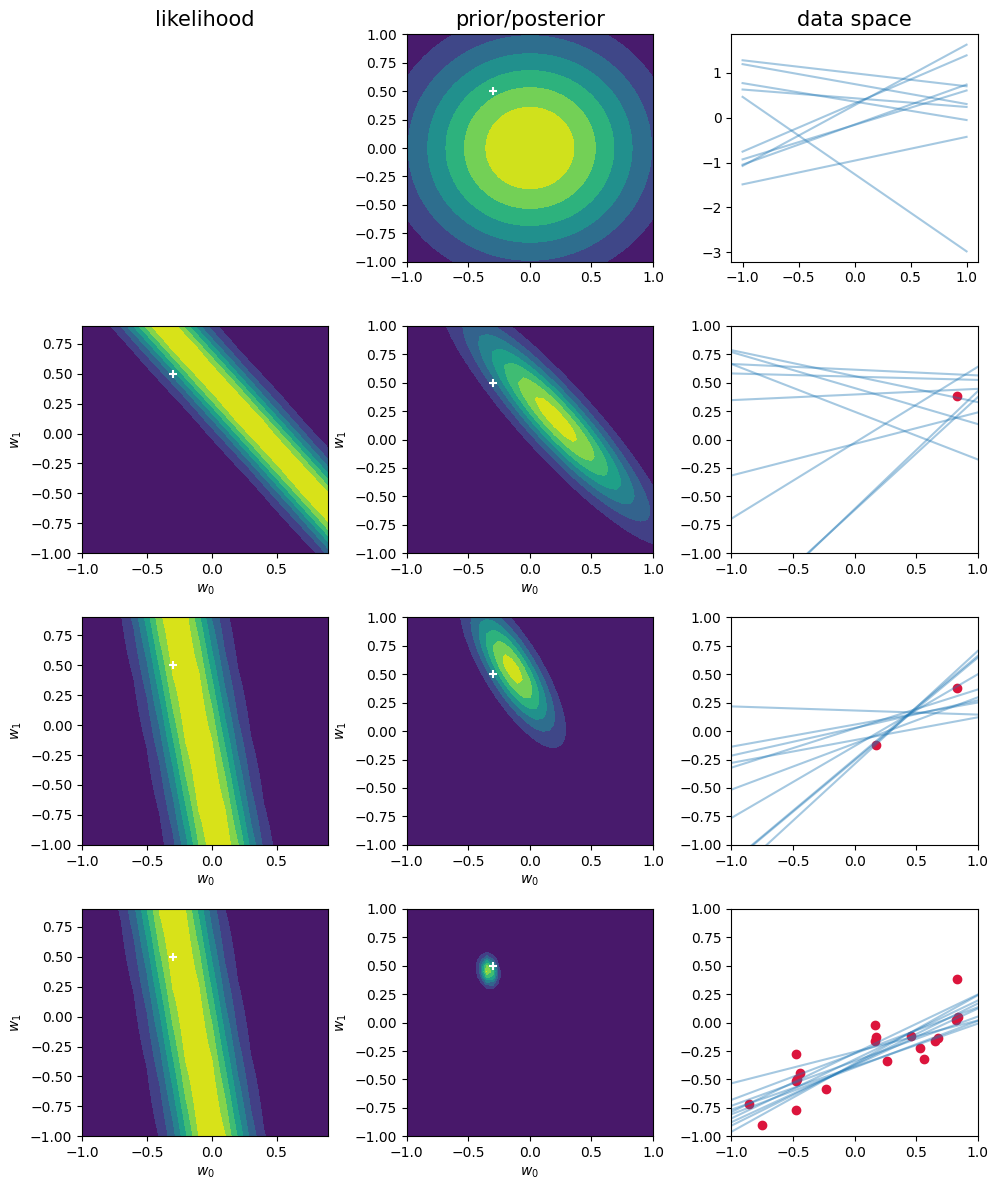

In [57]:
SN = np.eye(2) / alpha
mN = np.zeros((2, 1))

seed(1643)
N = 20
nobs = [1, 2, 20]
ix_fig = 1
fig, ax = plt.subplots(len(nobs) + 1, 3, figsize=(10, 12))
plot_prior(mN, SN, ax=ax[0,1])
ax[0, 1].scatter(-0.3, 0.5, c="white", marker="+")
ax[0, 0].axis("off")
plot_sample_w(mN, SN, ax=ax[0, 2])
for i in range(0, N+1):
    Phi, t = sample_vals(X, T, i)
    SN, mN = posterior_w(Phi, t, SN, mN)
    if i+1 in nobs:
        plot_likelihood_obs(X, T, i, ax=ax[ix_fig, 0])
        plot_prior(mN, SN, ax=ax[ix_fig, 1])
        ax[ix_fig, 1].scatter(-0.3, 0.5, c="white", marker="+")
        ax[ix_fig, 2].scatter(X[:i + 1], T[:i + 1], c="crimson")
        ax[ix_fig, 2].set_xlim(-1, 1)
        ax[ix_fig, 2].set_ylim(-1, 1)
        for l in range(2):
            ax[ix_fig, l].set_xlabel("$w_0$")
            ax[ix_fig, l].set_ylabel("$w_1$")
        plot_sample_w(mN, SN, ax=ax[ix_fig, 2])
        ix_fig += 1

titles = ["likelihood", "prior/posterior", "data space"]
for axi, title in zip(ax[0], titles):
    axi.set_title(title, size=15)
plt.tight_layout()